In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['OMP_NUM_THREADS'] = '2'

In [10]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from heapq import heappop, heappush

class Node:
    def __init__(self, coord: (int, int) = (0, 0), g: int = 0, h: int = 0):
        self.i, self.j = coord
        self.g = g
        self.h = h
        self.f = g + h

    def __lt__(self, other):
        return self.f < other.f or ((self.f == other.f) and (self.g < other.g))


class AStar:
    def __init__(self):
        self.start = (0, 0)
        self.goal = (0, 0)
        self.max_steps = 1000  # due to the absence of information about the map size we need some other stop criterion
        self.OPEN = list()
        self.CLOSED = dict()
        self.obstacles = set()
        self.other_agents = set()

    def compute_shortest_path(self, start, goal, obs_radius=None):               
        self.start = start               
        self.goal = goal
        self.CLOSED = dict()
        self.OPEN = list()          
        
        heappush(self.OPEN, Node(self.start))
        u = Node()
        steps = 0
        while len(self.OPEN) > 0 and steps < self.max_steps and (u.i, u.j) != self.goal:
            u = heappop(self.OPEN)
            steps += 1
            for d in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                n = (u.i+d[0], u.j + d[1])
                if n not in self.obstacles and n not in self.CLOSED and n not in self.other_agents:
                    h = abs(n[0] - self.goal[0]) + abs(n[1] - self.goal[1])  # Manhattan distance as a heuristic function
                    heappush(self.OPEN, Node(n, u.g + 1, h))
                    self.CLOSED[n] = (u.i, u.j)  # store information about the predecessor

    def get_next_node(self):
        next_node = self.start  # if path not found, current start position is returned
        if self.goal in self.CLOSED:  # if path found
            next_node = self.goal
            while self.CLOSED[next_node] != self.start:  # get node in the path with start node as a predecessor
                next_node = self.CLOSED[next_node]
        return next_node

    def update_obstacles(self, obs, other_agents, n):
        obstacles = np.transpose(np.nonzero(obs))  # get the coordinates of all obstacles in current observation
        for obstacle in obstacles:
            self.obstacles.add((n[0] + obstacle[0], n[1] + obstacle[1]))  # save them with correct coordinates
        self.other_agents.clear()  # forget previously seen agents as they move
        agents = np.transpose(np.nonzero(other_agents))  # get the coordinates of all agents that are seen
        for agent in agents:
            self.other_agents.add((n[0] + agent[0], n[1] + agent[1]))  # save them with correct coordinates

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input_shape=363
        self.num_actions=5
        self.load_weights=True

        self.learning_rate = 0.0005
        self.gamma         = 0.98
        self.lmbda         = 0.95
        self.eps_clip      = 0.1
        self.K_epoch       = 3
        self.T_horizon     = 120

        self.data = []
             
        self.fc1   = nn.Linear(self.input_shape, 256)
        self.fc_pi = nn.Linear(256, self.num_actions)
        self.fc_v  = nn.Linear(256, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        
        self.agents = None
        self.actions = {tuple(GridConfig().MOVES[i]): i for i in
                        range(len(GridConfig().MOVES))}
        if self.load_weights:
            self.load_state_dict(torch.load("pogema_ppo_weights.h5"))
            self.eval()


    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()
        if s.shape == (1, 0):
            return

        for i in range(self.K_epoch):            
            td_target = r + self.gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = self.gamma * self.lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s), td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

    def act(self, obs, done, positions_xy, targets_xy):
        """
        Given current observations, Done flags, agents' current positions and their targets, produce actions for agents.
        """
        
        obs_radius = 5
        if self.agents is None:
            self.agents = [AStar() for _ in range(len(obs))] 
        
        actions = []
        for state in obs:
            s_current = state.flatten()
            prob = self.pi(torch.from_numpy(s_current).float())            
            m = Categorical(prob)
            a = m.sample().item()
            actions.append(a)
        
        for k in range(len(obs)):
            prev_obstacles = self.agents[k].obstacles
            self.agents[k].update_obstacles(obs[k][0], obs[k][1], (positions_xy[k][0] - 5, positions_xy[k][1] - 5))
            new_obstacles = self.agents[k].obstacles
            if prev_obstacles == new_obstacles:
                self.agents[k].compute_shortest_path(start=positions_xy[k], goal=targets_xy[k])
                next_node = self.agents[k].get_next_node()
                k_act = self.actions[(next_node[0] - positions_xy[k][0], next_node[1] - positions_xy[k][1])]
                if k_act != 0:
                    actions[k] = k_act
            
            if positions_xy[k] == targets_xy[k]:                  
                actions[k] = 0  
                continue
            if np.abs(positions_xy[k][0]-targets_xy[k][0]) <= obs_radius and np.abs(positions_xy[k][1]-targets_xy[k][1]) <= obs_radius: 
                self.agents[k].compute_shortest_path(start=positions_xy[k], goal=targets_xy[k])
                next_node = self.agents[k].get_next_node()
                k_act = self.actions[(next_node[0] - positions_xy[k][0], next_node[1] - positions_xy[k][1])]
                if k_act != 0:
                    actions[k] = k_act
        
        
        return actions

In [15]:
import gym
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from IPython.display import SVG, display
import numpy as np
import pogema
from pogema import GridConfig

# Define random configuration
grid_config = GridConfig(num_agents=8,  # количество агентов на карте
                         size=32,  # размеры карты
                         density=0.3,  # плотность препятствий
                         seed=3,  # сид генерации задания
                         max_episode_steps=256,  # максимальная длина эпизода
                         obs_radius=5,  # радиус обзора
                         )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

done = [False for k in range(len(obs))]
solver = Model()
steps = 0


while not all(done):
    
    # Используем AStar
    obs, reward, done, info = env.step(solver.act(obs, done, env.get_agents_xy_relative(), env.get_targets_xy_relative()))
    steps += 1
    #print(steps, np.sum(done))

#print(env.get_agents_xy_relative(),env.get_targets_xy_relative())
# сохраняем анимацию и рисуем ее
env.save_animation("render.svg", egocentric_idx=None)

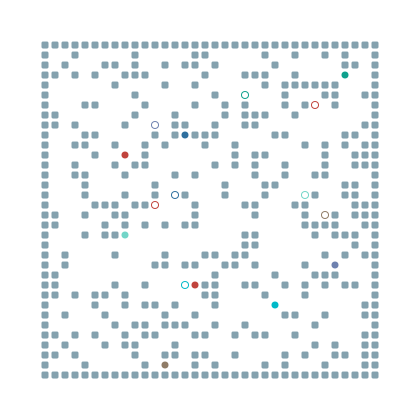

In [16]:
display(SVG('render.svg'))